# Setting

In [15]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Data Load

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                          shuffle=True, num_workers=10)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                         shuffle=False, num_workers=10)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# check data size
print(train_set.__getitem__(0)[0].size(), train_set.__len__())
print(test_set.__getitem__(0)[0].size(), test_set.__len__())

torch.Size([3, 32, 32]) 50000
torch.Size([3, 32, 32]) 10000


# EDA

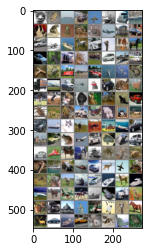

 bird frog shiptruck


In [5]:
import matplotlib.pylab as plt
import numpy as np

def img_show(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

img_show(torchvision.utils.make_grid(images))

print(''.join('%5s' % classes[labels[j]] for j in range(4)))

# CNN

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 24, 5)
        self.b1 = nn.BatchNorm2d(24)
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Conv2d(24, 64, 5)
        self.b2 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.b1((self.conv1(x)))))
        x = self.pool(F.relu(self.b2(self.conv2(x))))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
cnn = CNN()
cnn

CNN(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1))
  (b1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1))
  (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Cost Function & Optimizer 

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters())

# Train

In [22]:
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        
        inputs, labels = Variable(inputs), Variable(labels)
        
        optimizer.zero_grad()
        
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 128 == 127:   # print every 128 mini-batches
            print('[%d, %5d] loss : %.3f' % (epoch + 1, i+ 1, running_loss / 128))
            running_loss = 0.0
    
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data
        outputs = cnn(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('Accuracy 2500 test images : %d %%'% (100 * correct//total))
    
print('Finished Training')

torch.save(cnn.state_dict(), 'CNN.pkl')

[1,   128] loss : 0.835
[1,   256] loss : 0.854
[1,   384] loss : 0.809
Accuracy 2500 test images : 62 %
[2,   128] loss : 0.730
[2,   256] loss : 0.738
[2,   384] loss : 0.744
Accuracy 2500 test images : 62 %
[3,   128] loss : 0.652
[3,   256] loss : 0.656
[3,   384] loss : 0.658
Accuracy 2500 test images : 65 %
[4,   128] loss : 0.585
[4,   256] loss : 0.582
[4,   384] loss : 0.615
Accuracy 2500 test images : 67 %
[5,   128] loss : 0.512
[5,   256] loss : 0.533
[5,   384] loss : 0.535
Accuracy 2500 test images : 65 %
Finished Training


In [24]:
for data in test_loader:
    images, labels = data
    print(labels.size())
    print(labels)
    print(labels.size(0))

torch.Size([4])
tensor([3, 8, 8, 0])
4
torch.Size([4])
tensor([6, 6, 1, 6])
4
torch.Size([4])
tensor([3, 1, 0, 9])
4
torch.Size([4])
tensor([5, 7, 9, 8])
4
torch.Size([4])
tensor([5, 7, 8, 6])
4
torch.Size([4])
tensor([7, 0, 4, 9])
4
torch.Size([4])
tensor([5, 2, 4, 0])
4
torch.Size([4])
tensor([9, 6, 6, 5])
4
torch.Size([4])
tensor([4, 5, 9, 2])
4
torch.Size([4])
tensor([4, 1, 9, 5])
4
torch.Size([4])
tensor([4, 6, 5, 6])
4
torch.Size([4])
tensor([0, 9, 3, 9])
4
torch.Size([4])
tensor([7, 6, 9, 8])
4
torch.Size([4])
tensor([0, 3, 8, 8])
4
torch.Size([4])
tensor([7, 7, 4, 6])
4
torch.Size([4])
tensor([7, 3, 6, 3])
4
torch.Size([4])
tensor([6, 2, 1, 2])
4
torch.Size([4])
tensor([3, 7, 2, 6])
4
torch.Size([4])
tensor([8, 8, 0, 2])
4
torch.Size([4])
tensor([9, 3, 3, 8])
4
torch.Size([4])
tensor([8, 1, 1, 7])
4
torch.Size([4])
tensor([2, 5, 2, 7])
4
torch.Size([4])
tensor([8, 9, 0, 3])
4
torch.Size([4])
tensor([8, 6, 4, 6])
4
torch.Size([4])
tensor([6, 0, 0, 7])
4
torch.Size([4])
tensor([4

torch.Size([4])
tensor([0, 4, 0, 1])
4
torch.Size([4])
tensor([3, 8, 8, 0])
4
torch.Size([4])
tensor([6, 9, 9, 9])
4
torch.Size([4])
tensor([5, 5, 8, 6])
4
torch.Size([4])
tensor([0, 0, 4, 2])
4
torch.Size([4])
tensor([3, 2, 7, 2])
4
torch.Size([4])
tensor([2, 5, 9, 8])
4
torch.Size([4])
tensor([9, 1, 7, 4])
4
torch.Size([4])
tensor([0, 3, 0, 1])
4
torch.Size([4])
tensor([3, 8, 3, 9])
4
torch.Size([4])
tensor([6, 1, 4, 7])
4
torch.Size([4])
tensor([0, 3, 7, 8])
4
torch.Size([4])
tensor([9, 1, 1, 6])
4
torch.Size([4])
tensor([6, 6, 6, 9])
4
torch.Size([4])
tensor([1, 9, 9, 4])
4
torch.Size([4])
tensor([2, 1, 7, 0])
4
torch.Size([4])
tensor([6, 8, 1, 9])
4
torch.Size([4])
tensor([2, 9, 0, 4])
4
torch.Size([4])
tensor([7, 8, 3, 1])
4
torch.Size([4])
tensor([2, 0, 1, 5])
4
torch.Size([4])
tensor([8, 4, 6, 3])
4
torch.Size([4])
tensor([8, 1, 3, 8])
4
torch.Size([4])
tensor([5, 0, 8, 4])
4
torch.Size([4])
tensor([8, 1, 1, 8])
4
torch.Size([4])
tensor([9, 6, 0, 8])
4
torch.Size([4])
tensor([6

tensor([3, 0, 7, 7])
4
torch.Size([4])
tensor([8, 1, 1, 4])
4
torch.Size([4])
tensor([6, 0, 6, 6])
4
torch.Size([4])
tensor([5, 5, 6, 3])
4
torch.Size([4])
tensor([9, 3, 6, 8])
4
torch.Size([4])
tensor([7, 6, 4, 9])
4
torch.Size([4])
tensor([5, 6, 4, 1])
4
torch.Size([4])
tensor([6, 3, 8, 2])
4
torch.Size([4])
tensor([3, 9, 8, 5])
4
torch.Size([4])
tensor([1, 5, 4, 5])
4
torch.Size([4])
tensor([7, 5, 7, 8])
4
torch.Size([4])
tensor([9, 1, 7, 2])
4
torch.Size([4])
tensor([5, 6, 8, 4])
4
torch.Size([4])
tensor([6, 5, 3, 9])
4
torch.Size([4])
tensor([9, 8, 5, 5])
4
torch.Size([4])
tensor([6, 4, 5, 9])
4
torch.Size([4])
tensor([7, 3, 4, 1])
4
torch.Size([4])
tensor([4, 2, 3, 6])
4
torch.Size([4])
tensor([5, 5, 2, 8])
4
torch.Size([4])
tensor([0, 0, 1, 8])
4
torch.Size([4])
tensor([3, 1, 3, 5])
4
torch.Size([4])
tensor([8, 3, 8, 5])
4
torch.Size([4])
tensor([8, 6, 3, 5])
4
torch.Size([4])
tensor([5, 5, 0, 9])
4
torch.Size([4])
tensor([5, 5, 7, 1])
4
torch.Size([4])
tensor([8, 2, 2, 7])
4
to

tensor([5, 8, 8, 0])
4
torch.Size([4])
tensor([9, 7, 9, 0])
4
torch.Size([4])
tensor([6, 9, 6, 1])
4
torch.Size([4])
tensor([4, 7, 9, 0])
4
torch.Size([4])
tensor([3, 5, 4, 7])
4
torch.Size([4])
tensor([6, 9, 8, 2])
4
torch.Size([4])
tensor([3, 9, 3, 3])
4
torch.Size([4])
tensor([7, 8, 3, 5])
4
torch.Size([4])
tensor([5, 9, 6, 1])
4
torch.Size([4])
tensor([4, 7, 4, 8])
4
torch.Size([4])
tensor([7, 7, 1, 3])
4
torch.Size([4])
tensor([0, 3, 2, 5])
4
torch.Size([4])
tensor([4, 9, 3, 5])
4
torch.Size([4])
tensor([4, 7, 0, 3])
4
torch.Size([4])
tensor([7, 0, 2, 1])
4
torch.Size([4])
tensor([5, 8, 7, 3])
4
torch.Size([4])
tensor([5, 7, 8, 5])
4
torch.Size([4])
tensor([7, 8, 1, 5])
4
torch.Size([4])
tensor([4, 7, 0, 8])
4
torch.Size([4])
tensor([3, 2, 9, 7])
4
torch.Size([4])
tensor([4, 1, 6, 5])
4
torch.Size([4])
tensor([9, 8, 5, 5])
4
torch.Size([4])
tensor([4, 1, 0, 9])
4
torch.Size([4])
tensor([4, 4, 3, 0])
4
torch.Size([4])
tensor([4, 8, 0, 8])
4
torch.Size([4])
tensor([2, 9, 5, 9])
4
to

torch.Size([4])
tensor([0, 0, 9, 0])
4
torch.Size([4])
tensor([4, 2, 8, 8])
4
torch.Size([4])
tensor([5, 5, 0, 4])
4
torch.Size([4])
tensor([0, 8, 6, 2])
4
torch.Size([4])
tensor([5, 9, 2, 9])
4
torch.Size([4])
tensor([1, 1, 5, 4])
4
torch.Size([4])
tensor([7, 5, 8, 6])
4
torch.Size([4])
tensor([2, 1, 5, 5])
4
torch.Size([4])
tensor([3, 4, 1, 8])
4
torch.Size([4])
tensor([9, 9, 8, 9])
4
torch.Size([4])
tensor([8, 6, 8, 5])
4
torch.Size([4])
tensor([8, 9, 4, 6])
4
torch.Size([4])
tensor([2, 6, 3, 7])
4
torch.Size([4])
tensor([4, 0, 0, 1])
4
torch.Size([4])
tensor([7, 5, 1, 5])
4
torch.Size([4])
tensor([9, 3, 1, 6])
4
torch.Size([4])
tensor([8, 7, 3, 6])
4
torch.Size([4])
tensor([9, 1, 2, 0])
4
torch.Size([4])
tensor([1, 7, 2, 6])
4
torch.Size([4])
tensor([1, 9, 0, 0])
4
torch.Size([4])
tensor([8, 9, 9, 2])
4
torch.Size([4])
tensor([8, 6, 2, 5])
4
torch.Size([4])
tensor([6, 0, 3, 3])
4
torch.Size([4])
tensor([0, 7, 4, 7])
4
torch.Size([4])
tensor([5, 0, 1, 6])
4
torch.Size([4])
tensor([8

tensor([3, 4, 6, 7])
4
torch.Size([4])
tensor([5, 2, 0, 1])
4
torch.Size([4])
tensor([5, 5, 1, 4])
4
torch.Size([4])
tensor([1, 3, 0, 8])
4
torch.Size([4])
tensor([6, 2, 1, 3])
4
torch.Size([4])
tensor([6, 4, 1, 9])
4
torch.Size([4])
tensor([0, 4, 1, 0])
4
torch.Size([4])
tensor([1, 9, 8, 6])
4
torch.Size([4])
tensor([9, 2, 4, 7])
4
torch.Size([4])
tensor([2, 2, 7, 4])
4
torch.Size([4])
tensor([9, 1, 3, 2])
4
torch.Size([4])
tensor([6, 3, 4, 4])
4
torch.Size([4])
tensor([9, 4, 8, 2])
4
torch.Size([4])
tensor([6, 6, 1, 6])
4
torch.Size([4])
tensor([3, 6, 5, 8])
4
torch.Size([4])
tensor([4, 6, 7, 1])
4
torch.Size([4])
tensor([9, 3, 6, 7])
4
torch.Size([4])
tensor([6, 0, 7, 1])
4
torch.Size([4])
tensor([9, 5, 2, 6])
4
torch.Size([4])
tensor([7, 7, 6, 5])
4
torch.Size([4])
tensor([9, 1, 5, 6])
4
torch.Size([4])
tensor([0, 2, 0, 9])
4
torch.Size([4])
tensor([1, 8, 3, 5])
4
torch.Size([4])
tensor([0, 0, 0, 5])
4
torch.Size([4])
tensor([7, 7, 8, 5])
4
torch.Size([4])
tensor([5, 5, 1, 6])
4
to

tensor([1, 6, 9, 3])
4
torch.Size([4])
tensor([8, 9, 5, 8])
4
torch.Size([4])
tensor([3, 9, 4, 3])
4
torch.Size([4])
tensor([7, 5, 5, 2])
4
torch.Size([4])
tensor([7, 5, 7, 9])
4
torch.Size([4])
tensor([6, 3, 0, 8])
4
torch.Size([4])
tensor([4, 5, 6, 1])
4
torch.Size([4])
tensor([0, 4, 8, 4])
4
torch.Size([4])
tensor([7, 1, 3, 2])
4
torch.Size([4])
tensor([0, 9, 1, 8])
4
torch.Size([4])
tensor([8, 6, 8, 1])
4
torch.Size([4])
tensor([7, 1, 0, 9])
4
torch.Size([4])
tensor([7, 6, 4, 5])
4
torch.Size([4])
tensor([8, 2, 1, 2])
4
torch.Size([4])
tensor([5, 8, 1, 1])
4
torch.Size([4])
tensor([8, 8, 0, 9])
4
torch.Size([4])
tensor([0, 0, 4, 3])
4
torch.Size([4])
tensor([3, 5, 6, 6])
4
torch.Size([4])
tensor([3, 1, 4, 4])
4
torch.Size([4])
tensor([7, 8, 0, 1])
4
torch.Size([4])
tensor([4, 8, 4, 6])
4
torch.Size([4])
tensor([2, 2, 2, 6])
4
torch.Size([4])
tensor([3, 4, 0, 8])
4
torch.Size([4])
tensor([1, 3, 8, 3])
4
torch.Size([4])
tensor([8, 9, 1, 6])
4
torch.Size([4])
tensor([1, 9, 8, 2])
4
to

tensor([0, 5, 7, 1])
4
torch.Size([4])
tensor([5, 4, 0, 8])
4
torch.Size([4])
tensor([4, 9, 8, 7])
4
torch.Size([4])
tensor([8, 4, 2, 3])
4
torch.Size([4])
tensor([4, 0, 5, 4])
4
torch.Size([4])
tensor([1, 8, 2, 5])
4
torch.Size([4])
tensor([4, 5, 2, 5])
4
torch.Size([4])
tensor([3, 7, 9, 7])
4
torch.Size([4])
tensor([1, 4, 1, 3])
4
torch.Size([4])
tensor([1, 4, 5, 5])
4
torch.Size([4])
tensor([1, 7, 1, 3])
4
torch.Size([4])
tensor([0, 1, 2, 5])
4
torch.Size([4])
tensor([7, 0, 6, 3])
4
torch.Size([4])
tensor([5, 7, 5, 5])
4
torch.Size([4])
tensor([8, 9, 4, 6])
4
torch.Size([4])
tensor([3, 6, 6, 8])
4
torch.Size([4])
tensor([2, 6, 4, 8])
4
torch.Size([4])
tensor([4, 1, 3, 1])
4
torch.Size([4])
tensor([2, 3, 3, 0])
4
torch.Size([4])
tensor([1, 6, 4, 2])
4
torch.Size([4])
tensor([8, 2, 4, 3])
4
torch.Size([4])
tensor([1, 4, 4, 4])
4
torch.Size([4])
tensor([4, 1, 5, 5])
4
torch.Size([4])
tensor([7, 6, 5, 4])
4
torch.Size([4])
tensor([5, 6, 5, 6])
4
torch.Size([4])
tensor([2, 4, 7, 7])
4
to

tensor([3, 3, 5, 3])
4
torch.Size([4])
tensor([3, 2, 7, 7])
4
torch.Size([4])
tensor([8, 2, 0, 5])
4
torch.Size([4])
tensor([5, 6, 1, 1])
4
torch.Size([4])
tensor([3, 9, 9, 3])
4
torch.Size([4])
tensor([6, 7, 1, 8])
4
torch.Size([4])
tensor([3, 9, 8, 7])
4
torch.Size([4])
tensor([8, 8, 0, 3])
4
torch.Size([4])
tensor([2, 4, 8, 7])
4
torch.Size([4])
tensor([5, 7, 1, 8])
4
torch.Size([4])
tensor([7, 3, 5, 4])
4
torch.Size([4])
tensor([4, 3, 8, 6])
4
torch.Size([4])
tensor([1, 1, 6, 3])
4
torch.Size([4])
tensor([2, 2, 8, 9])
4
torch.Size([4])
tensor([8, 3, 3, 8])
4
torch.Size([4])
tensor([1, 1, 0, 5])
4
torch.Size([4])
tensor([2, 0, 5, 0])
4
torch.Size([4])
tensor([5, 8, 6, 3])
4
torch.Size([4])
tensor([9, 6, 6, 3])
4
torch.Size([4])
tensor([9, 4, 8, 3])
4
torch.Size([4])
tensor([4, 3, 1, 1])
4
torch.Size([4])
tensor([2, 9, 7, 8])
4
torch.Size([4])
tensor([5, 5, 8, 6])
4
torch.Size([4])
tensor([9, 0, 8, 3])
4
torch.Size([4])
tensor([5, 1, 3, 3])
4
torch.Size([4])
tensor([5, 5, 3, 8])
4
to

tensor([7, 1, 7, 4])
4
torch.Size([4])
tensor([5, 4, 3, 3])
4
torch.Size([4])
tensor([2, 0, 6, 6])
4
torch.Size([4])
tensor([0, 1, 3, 9])
4
torch.Size([4])
tensor([8, 3, 7, 8])
4
torch.Size([4])
tensor([9, 4, 8, 9])
4
torch.Size([4])
tensor([0, 9, 7, 1])
4
torch.Size([4])
tensor([6, 2, 9, 5])
4
torch.Size([4])
tensor([6, 9, 3, 9])
4
torch.Size([4])
tensor([8, 7, 7, 1])
4
torch.Size([4])
tensor([6, 5, 3, 1])
4
torch.Size([4])
tensor([3, 1, 2, 7])
4
torch.Size([4])
tensor([1, 8, 2, 0])
4
torch.Size([4])
tensor([9, 7, 9, 8])
4
torch.Size([4])
tensor([8, 6, 7, 3])
4
torch.Size([4])
tensor([7, 1, 3, 9])
4
torch.Size([4])
tensor([0, 9, 3, 6])
4
torch.Size([4])
tensor([7, 2, 7, 3])
4
torch.Size([4])
tensor([0, 5, 9, 7])
4
torch.Size([4])
tensor([5, 5, 0, 6])
4
torch.Size([4])
tensor([5, 1, 8, 2])
4
torch.Size([4])
tensor([7, 5, 9, 0])
4
torch.Size([4])
tensor([0, 0, 8, 8])
4
torch.Size([4])
tensor([7, 3, 7, 8])
4
torch.Size([4])
tensor([9, 3, 7, 9])
4
torch.Size([4])
tensor([7, 8, 7, 9])
4
to

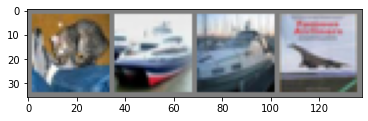

GroundTruth :     cat  ship  ship plane


In [33]:
# test
dataiter = iter(test_loader)
images, labels = dataiter.next()

img_show(torchvision.utils.make_grid(images))
print('GroundTruth : ',''.join('%6s' % classes[labels[j]] for j in range(4)))

In [34]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   frog   dog   car horse


In [37]:
correct = 0
total = 0
for data in test_loader:
    images, labels = data
    outputs = cnn(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accurcay to 10000 test images : %d %%' %(100* correct // total))

Accurcay to 10000 test images : 65 %


In [38]:
class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]
for data in test_loader:
    images, labels = data
    outputs = cnn(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
        
for i in range(10):
    print('Accuray of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuray of plane : 82 %
Accuray of   car : 74 %
Accuray of  bird : 51 %
Accuray of   cat : 51 %
Accuray of  deer : 58 %
Accuray of   dog : 48 %
Accuray of  frog : 69 %
Accuray of horse : 66 %
Accuray of  ship : 73 %
Accuray of truck : 81 %
